# Q1

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
ratings = pd.read_csv('ratings.csv')
links = pd.read_csv('links.csv')
movies = pd.read_csv('movies.csv')
tags = pd.read_csv('tags.csv')

total_ratings = len(ratings)
num_users = ratings['userId'].nunique()
num_movies = ratings['movieId'].nunique()

In [6]:
total_possible_ratings = num_users * num_movies
sparsity = total_ratings / total_possible_ratings

In [7]:
sparsity

0.016999683055613623

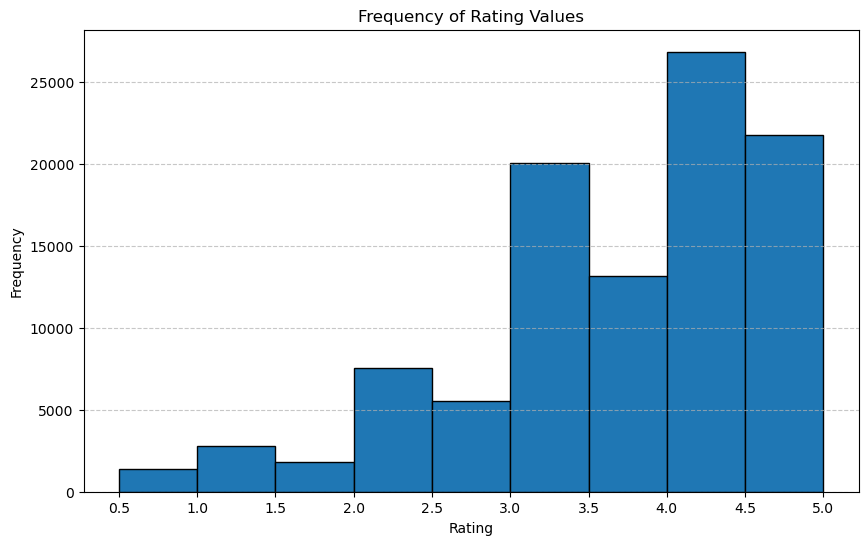

In [8]:
plt.figure(figsize=(10, 6))
plt.hist(ratings['rating'], bins=np.arange(0.5, 5.5, 0.5), edgecolor='black')
plt.title('Frequency of Rating Values')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks(np.arange(0.5, 5.5, 0.5))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

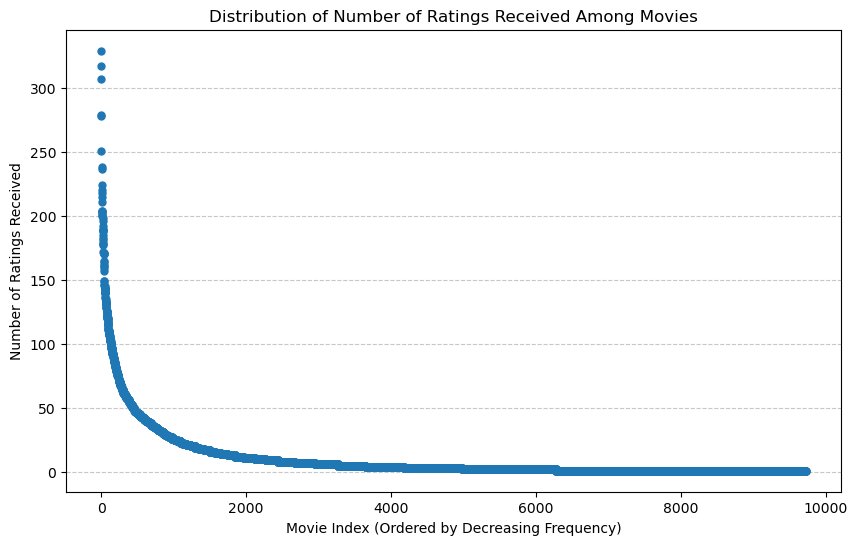

In [9]:
movie_ratings_count = ratings.groupby('movieId').size().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plt.plot(range(len(movie_ratings_count)), movie_ratings_count, marker='.', linestyle='None', markersize=10)
plt.title('Distribution of Number of Ratings Received Among Movies')
plt.xlabel('Movie Index (Ordered by Decreasing Frequency)')
plt.ylabel('Number of Ratings Received')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

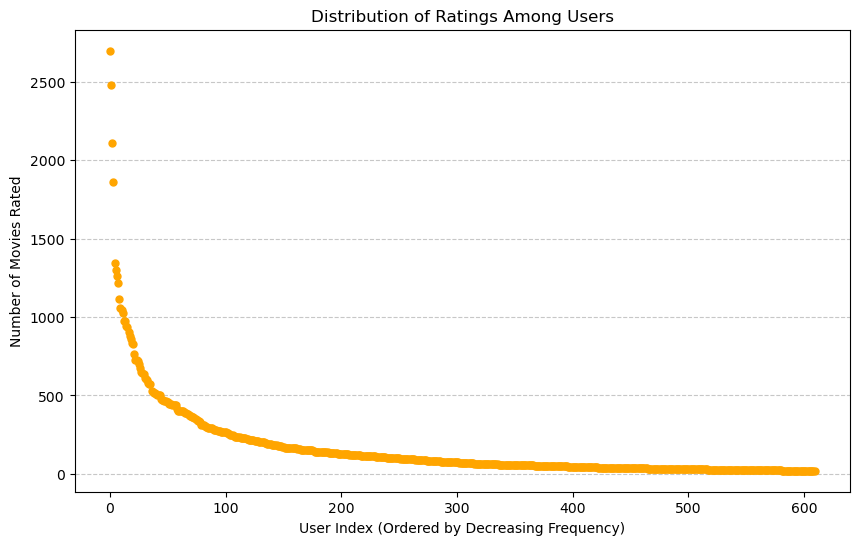

In [10]:
user_ratings_count = ratings.groupby('userId').size().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plt.plot(range(len(user_ratings_count)), user_ratings_count, marker='.', linestyle='None', color='orange', markersize=10)
plt.title('Distribution of Ratings Among Users')
plt.xlabel('User Index (Ordered by Decreasing Frequency)')
plt.ylabel('Number of Movies Rated')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

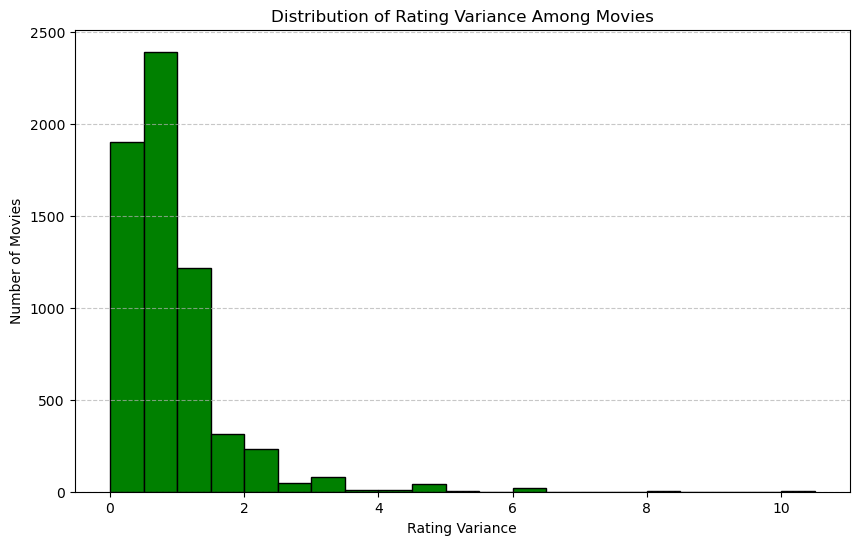

count    6278.000000
mean        0.857169
std         0.795839
min         0.000000
25%         0.395833
50%         0.702111
75%         1.105310
max        10.125000
Name: rating, dtype: float64

In [11]:
movie_rating_variance = ratings.groupby('movieId')['rating'].var().dropna()

# Plotting the histogram of movie rating variances
plt.figure(figsize=(10, 6))
plt.hist(movie_rating_variance, bins=np.arange(0, movie_rating_variance.max() + 0.5, 0.5), edgecolor='black', color='green')
plt.title('Distribution of Rating Variance Among Movies')
plt.xlabel('Rating Variance')
plt.ylabel('Number of Movies')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

movie_rating_variance.describe()

In [12]:
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate
from surprise import KNNWithMeans

reader = Reader(rating_scale=(0.5, 5))

data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Define the range of 'k' values for KNN (from 2 to 100 with steps of 2)
k_values = range(2, 101, 2)
# Initialize lists to store average RMSE and MAE values for each 'k'
avg_rmse = []
avg_mae = []

for k in k_values:
    algo = KNNWithMeans(k=k, sim_options={'name': 'pearson', 'user_based': True})
    results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10, verbose=False)

    avg_rmse.append(np.mean(results['test_rmse']))
    avg_mae.append(np.mean(results['test_mae']))

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

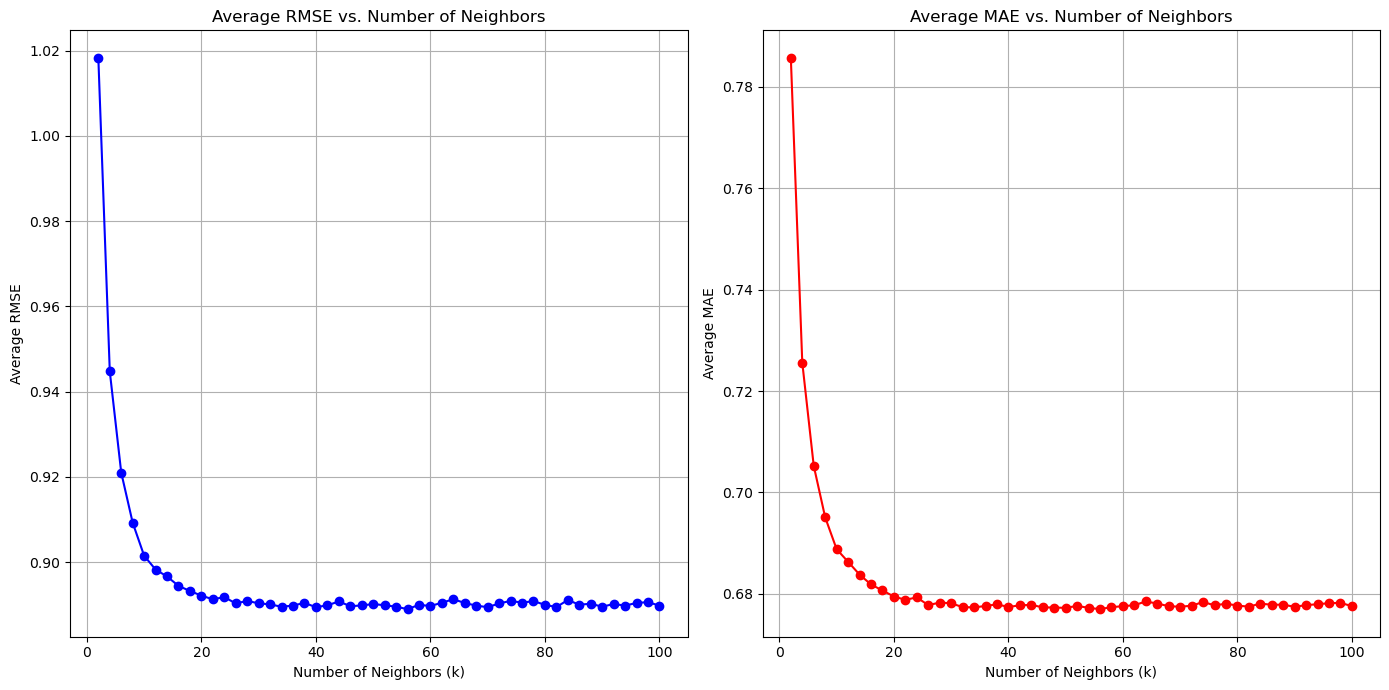

In [13]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(k_values, avg_rmse, marker='o', linestyle='-', color='b')
plt.title('Average RMSE vs. Number of Neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Average RMSE')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_values, avg_mae, marker='o', linestyle='-', color='r')
plt.title('Average MAE vs. Number of Neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Average MAE')
plt.grid(True)

plt.tight_layout()
plt.show()

# Q5

In [14]:
k_values[10], avg_rmse[10], avg_mae[10]

(22, 0.8912825371281731, 0.6788306540827981)

# Q6

In [15]:
from surprise.model_selection.split import KFold
from surprise.model_selection import train_test_split
from surprise import accuracy
from sklearn.metrics import roc_curve, auc

In [16]:
def popular_movies_trim(ratings_df):
    movie_rating_counts = ratings_df.groupby('movieId').size()
    popular_movies = movie_rating_counts[movie_rating_counts > 2].index
    return ratings_df[ratings_df['movieId'].isin(popular_movies)]

def unpopular_movies_trim(ratings_df):
    movie_rating_counts = ratings_df.groupby('movieId').size()
    unpopular_movies = movie_rating_counts[movie_rating_counts <= 2].index
    return ratings_df[ratings_df['movieId'].isin(unpopular_movies)]

def high_variance_movies_trim(ratings_df):
    movie_variances = ratings_df.groupby('movieId')['rating'].var()
    high_variance_movies = movie_variances[(movie_variances >= 2) & (ratings_df.groupby('movieId').size() >= 5)].index
    return ratings_df[ratings_df['movieId'].isin(high_variance_movies)]
# function for evaluate knn
def evaluate_knn(trimmed_data):
    kf = KFold(n_splits=10)
    avg_rmse = []

    for k in range(2, 101, 2):
        algo = KNNWithMeans(k=k, sim_options={'name': 'pearson', 'user_based': True})
        rmse = []
        for trainset, testset in kf.split(trimmed_data):
            algo.fit(trainset)
            predictions = algo.test(testset)
            rmse.append(accuracy.rmse(predictions, verbose=False))
        avg_rmse.append(sum(rmse) / len(rmse))
    return avg_rmse

In [17]:
# load the data
popular_trimmed_data = Dataset.load_from_df(popular_movies_trim(ratings)[['userId', 'movieId', 'rating']], reader)
unpopular_trimmed_data = Dataset.load_from_df(unpopular_movies_trim(ratings)[['userId', 'movieId', 'rating']], reader)
high_variance_trimmed_data = Dataset.load_from_df(high_variance_movies_trim(ratings)[['userId', 'movieId', 'rating']], reader)

print("Evaluating Popular Movies Trimmed Dataset")
popular_rmse = evaluate_knn(popular_trimmed_data)

Evaluating Popular Movies Trimmed Dataset
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity m

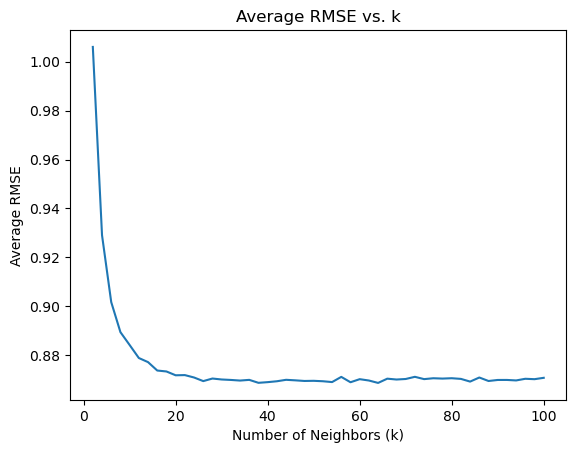

In [18]:
plt.plot(range(2, 101, 2), popular_rmse)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Average RMSE')
plt.title('Average RMSE vs. k')
plt.show()

In [19]:
print(min(popular_rmse))

0.8686969323525684


In [20]:
#print("Evaluating Unpopular Movies Trimmed Dataset")
unpopular_rmse = evaluate_knn(unpopular_trimmed_data)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

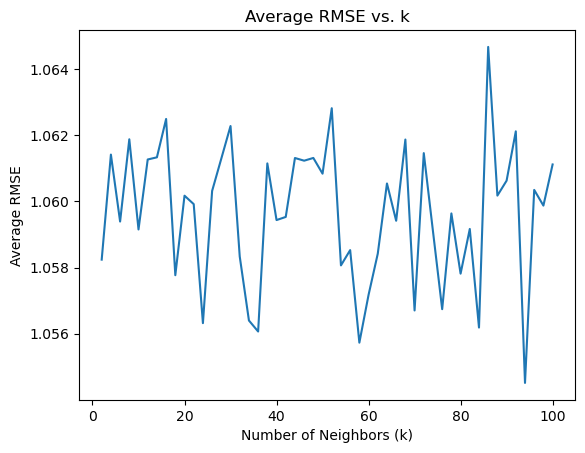

In [21]:
plt.plot(range(2, 101, 2), unpopular_rmse)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Average RMSE')
plt.title('Average RMSE vs. k')
plt.show()

In [22]:
print(min(unpopular_rmse))

1.0545134603418234


In [23]:

high_variance_rmse = evaluate_knn(high_variance_trimmed_data)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

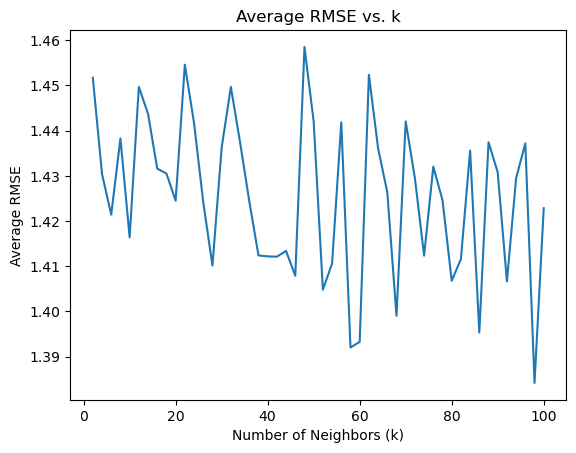

In [24]:
plt.plot(range(2, 101, 2), high_variance_rmse)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Average RMSE')
plt.title('Average RMSE vs. k')
plt.show()

In [25]:
print(min(high_variance_rmse))

1.3841707281721134


In [26]:
def roc_analysis(data, threshold, name):
    trainset, testset = train_test_split(data, test_size=0.1)
    algo = KNNWithMeans(sim_options={'name': 'pearson', 'user_based': True})
    algo.fit(trainset)
    predictions = algo.test(testset)

    y_true = [1 if pred.r_ui >= threshold else 0 for pred in predictions]
    y_score = [pred.est for pred in predictions]

    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic({name})')
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc

ROC Analysis for No Trimmed Dataset with threshold 2.5
Computing the pearson similarity matrix...
Done computing similarity matrix.


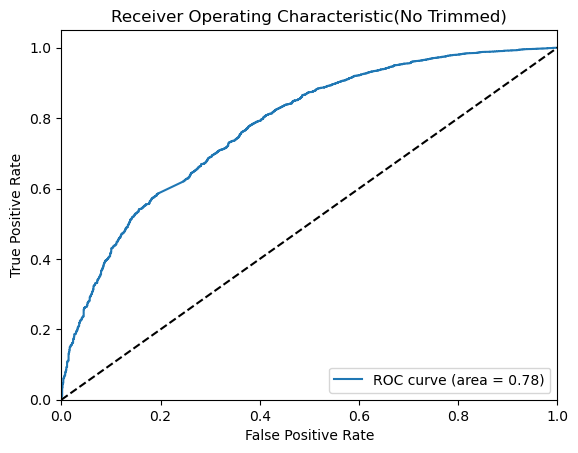

ROC Analysis for Popular Movies Trimmed Dataset with threshold 2.5
Computing the pearson similarity matrix...
Done computing similarity matrix.


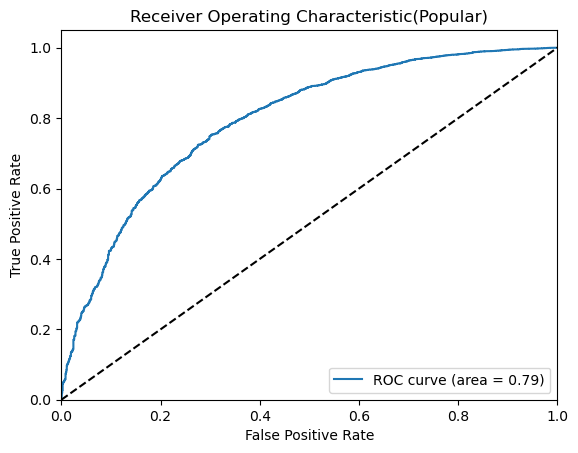

ROC Analysis for Unpopular Movies Trimmed Dataset with threshold 2.5
Computing the pearson similarity matrix...
Done computing similarity matrix.


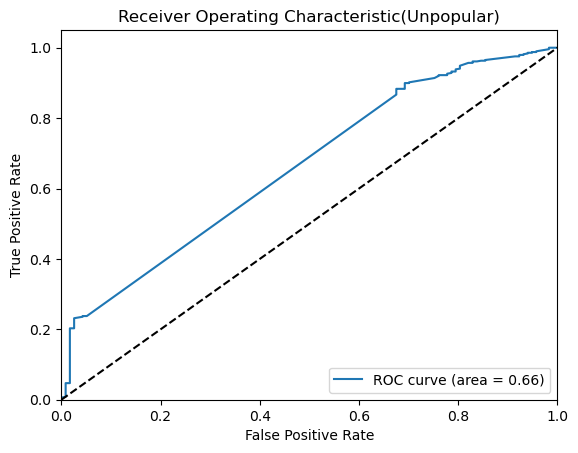

ROC Analysis for High Variance Movies Trimmed Dataset with threshold 2.5
Computing the pearson similarity matrix...
Done computing similarity matrix.


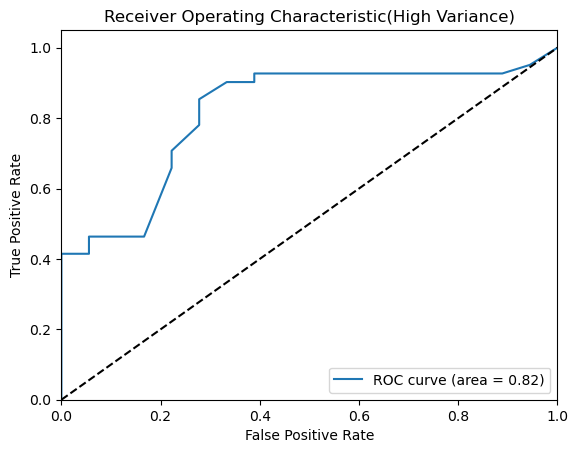

ROC Analysis for No Trimmed Dataset with threshold 3
Computing the pearson similarity matrix...
Done computing similarity matrix.


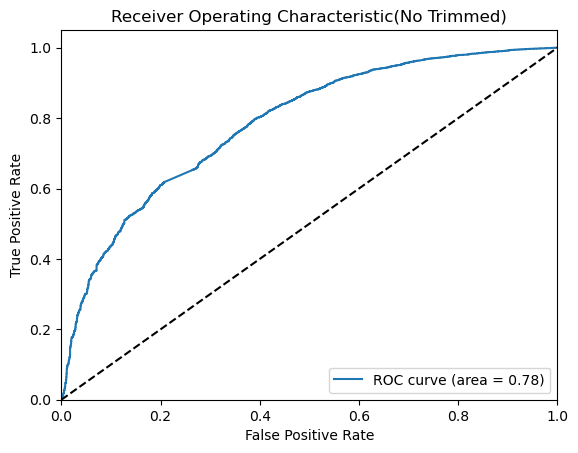

ROC Analysis for Popular Movies Trimmed Dataset with threshold 3
Computing the pearson similarity matrix...
Done computing similarity matrix.


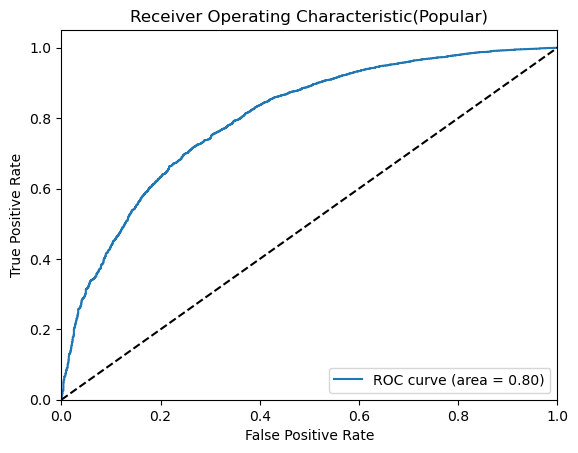

ROC Analysis for Unpopular Movies Trimmed Dataset with threshold 3
Computing the pearson similarity matrix...
Done computing similarity matrix.


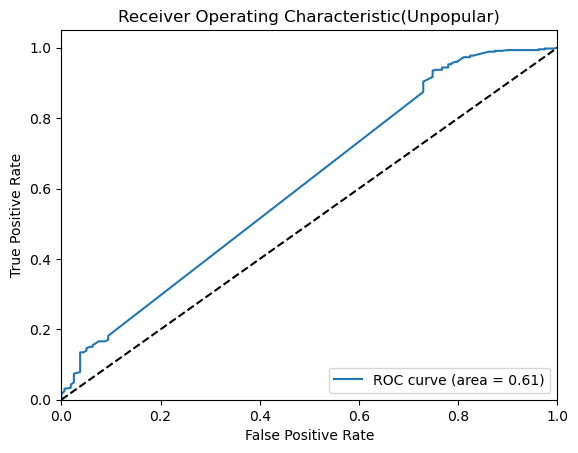

ROC Analysis for High Variance Movies Trimmed Dataset with threshold 3
Computing the pearson similarity matrix...
Done computing similarity matrix.


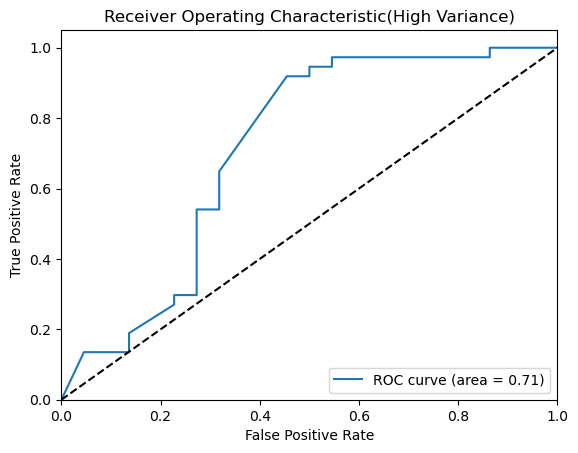

ROC Analysis for No Trimmed Dataset with threshold 3.5
Computing the pearson similarity matrix...
Done computing similarity matrix.


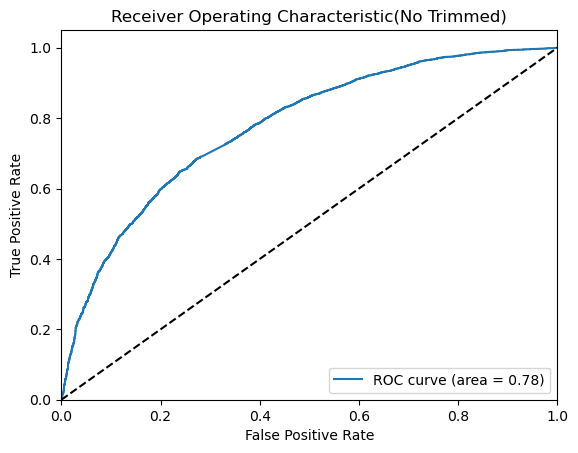

ROC Analysis for Popular Movies Trimmed Dataset with threshold 3.5
Computing the pearson similarity matrix...
Done computing similarity matrix.


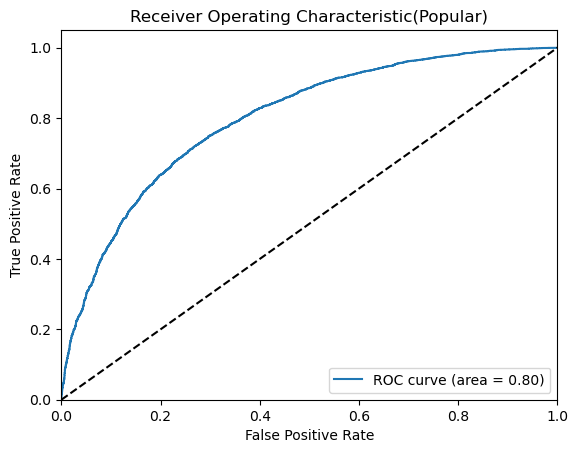

ROC Analysis for Unpopular Movies Trimmed Dataset with threshold 3.5
Computing the pearson similarity matrix...
Done computing similarity matrix.


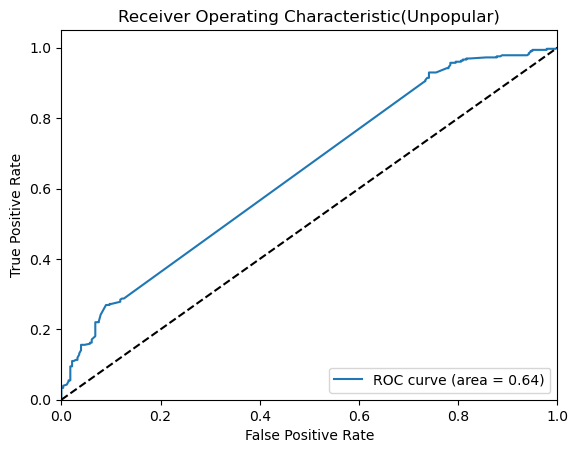

ROC Analysis for High Variance Movies Trimmed Dataset with threshold 3.5
Computing the pearson similarity matrix...
Done computing similarity matrix.


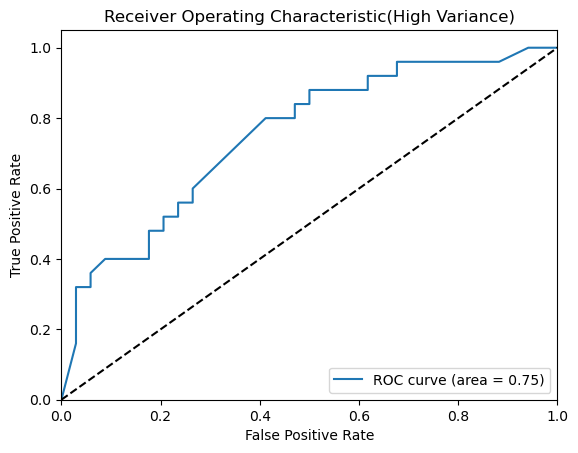

ROC Analysis for No Trimmed Dataset with threshold 4
Computing the pearson similarity matrix...
Done computing similarity matrix.


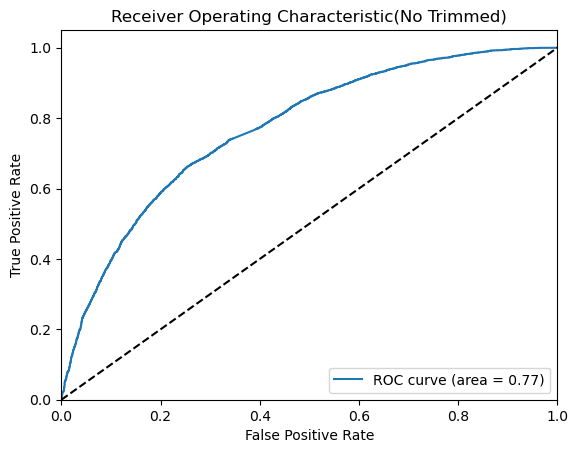

ROC Analysis for Popular Movies Trimmed Dataset with threshold 4
Computing the pearson similarity matrix...
Done computing similarity matrix.


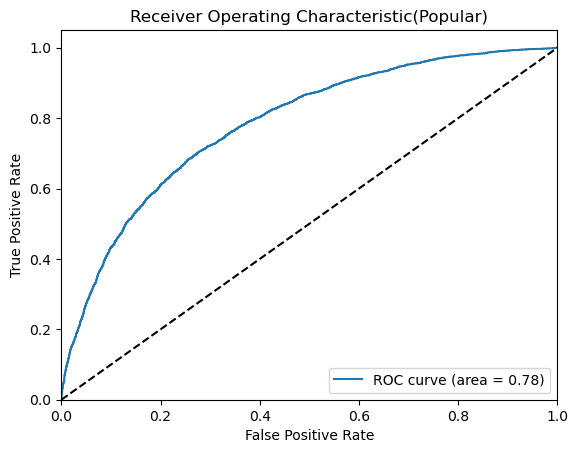

ROC Analysis for Unpopular Movies Trimmed Dataset with threshold 4
Computing the pearson similarity matrix...
Done computing similarity matrix.


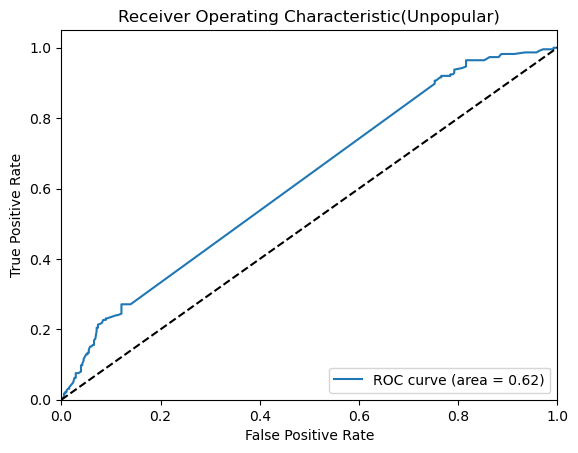

ROC Analysis for High Variance Movies Trimmed Dataset with threshold 4
Computing the pearson similarity matrix...
Done computing similarity matrix.


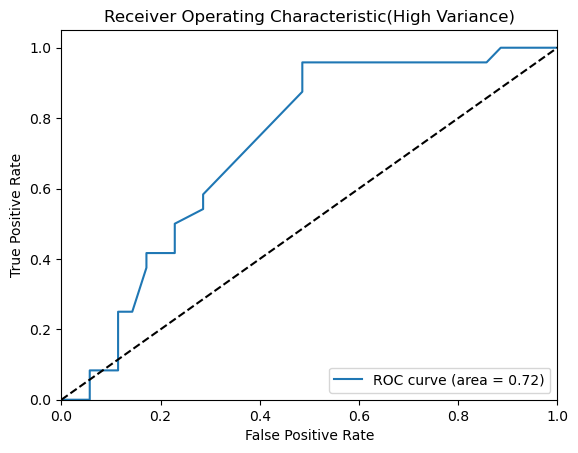

In [27]:
thresholds = [2.5, 3, 3.5, 4]
for threshold in thresholds:
    print(f"ROC Analysis for No Trimmed Dataset with threshold {threshold}")
    roc_auc_no = roc_analysis(data, threshold, 'No Trimmed')
    print(f"ROC Analysis for Popular Movies Trimmed Dataset with threshold {threshold}")
    roc_auc_popular = roc_analysis(popular_trimmed_data, threshold, 'Popular')
    print(f"ROC Analysis for Unpopular Movies Trimmed Dataset with threshold {threshold}")
    roc_auc_unpopular = roc_analysis(unpopular_trimmed_data, threshold, 'Unpopular')

    print(f"ROC Analysis for High Variance Movies Trimmed Dataset with threshold {threshold}")
    roc_auc_high_variance = roc_analysis(high_variance_trimmed_data, threshold, 'High Variance')

# Q8

In [28]:
from surprise import NMF

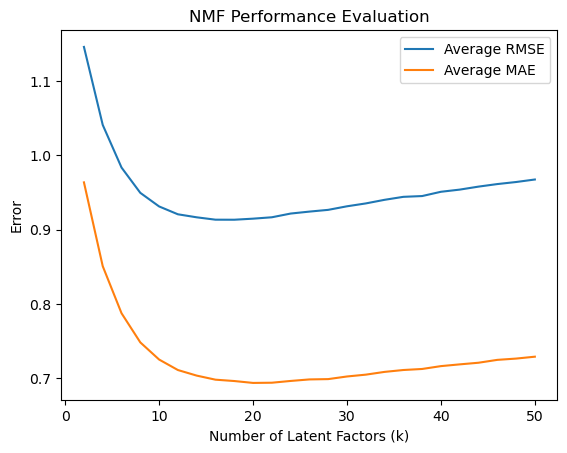

In [29]:
avg_rmse = []
avg_mae = []
for k in range(2, 51, 2):
    algo = NMF(n_factors=k)
    results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10, verbose=False)
    avg_rmse.append(sum(results['test_rmse']) / len(results['test_rmse']))
    avg_mae.append(sum(results['test_mae']) / len(results['test_mae']))

plt.plot(range(2, 51, 2), avg_rmse, label='Average RMSE')
plt.plot(range(2, 51, 2), avg_mae, label='Average MAE')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Error')
plt.title('NMF Performance Evaluation')
plt.legend()
plt.show()

In [30]:
np.unique('|'.join(movies['genres']).split('|'))


array(['(no genres listed)', 'Action', 'Adventure', 'Animation',
       'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western'], dtype='<U18')

In [31]:
len(np.unique('|'.join(movies['genres']).split('|'))) - 1

19

In [32]:
min_avg_rmse = min(avg_rmse)
min_avg_mae = min(avg_mae)
optimal_k_rmse = range(2, 51, 2)[avg_rmse.index(min_avg_rmse)]
optimal_k_mae = range(2, 51, 2)[avg_mae.index(min_avg_mae)]

print(f"Optimal number of latent factors for minimum average RMSE ({min_avg_rmse}): {optimal_k_rmse}")
print(f"Optimal number of latent factors for minimum average MAE ({min_avg_mae}): {optimal_k_mae}")

Optimal number of latent factors for minimum average RMSE (0.9132671124117154): 18
Optimal number of latent factors for minimum average MAE (0.6933927252723817): 20


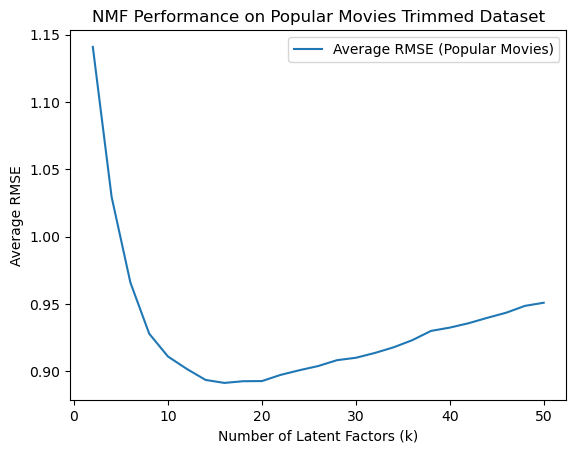

In [33]:
avg_rmse_popular = []
for k in range(2, 51, 2):
    algo = NMF(n_factors=k)
    results = cross_validate(algo, popular_trimmed_data, measures=['RMSE'], cv=10, verbose=False)
    avg_rmse_popular.append(sum(results['test_rmse']) / len(results['test_rmse']))

plt.plot(range(2, 51, 2), avg_rmse_popular, label='Average RMSE (Popular Movies)')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Average RMSE')
plt.title('NMF Performance on Popular Movies Trimmed Dataset')
plt.legend()
plt.show()

In [34]:
print(min(avg_rmse_popular))

0.8914090607594909


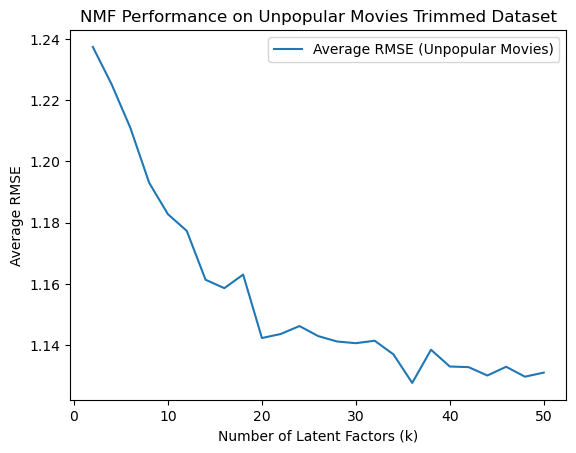

In [35]:
avg_rmse_unpopular = []
for k in range(2, 51, 2):
    algo = NMF(n_factors=k)
    results = cross_validate(algo, unpopular_trimmed_data, measures=['RMSE'], cv=10, verbose=False)
    avg_rmse_unpopular.append(sum(results['test_rmse']) / len(results['test_rmse']))

plt.plot(range(2, 51, 2), avg_rmse_unpopular, label='Average RMSE (Unpopular Movies)')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Average RMSE')
plt.title('NMF Performance on Unpopular Movies Trimmed Dataset')
plt.legend()
plt.show()

In [36]:
print(min(avg_rmse_unpopular))

1.1276475572893745


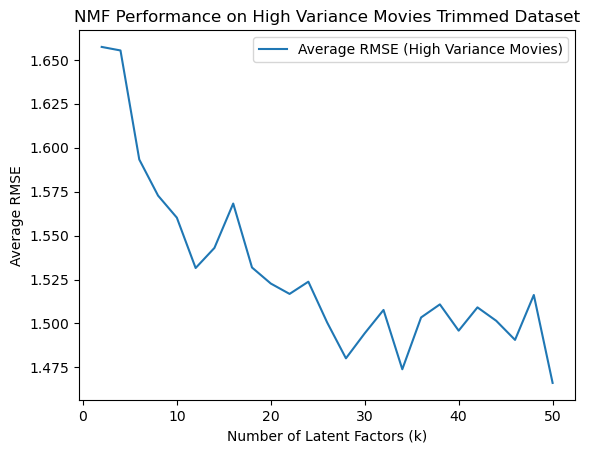

In [37]:

avg_rmse_high_variance = []
for k in range(2, 51, 2):
    algo = NMF(n_factors=k)
    results = cross_validate(algo, high_variance_trimmed_data, measures=['RMSE'], cv=10, verbose=False)
    avg_rmse_high_variance.append(sum(results['test_rmse']) / len(results['test_rmse']))

plt.plot(range(2, 51, 2), avg_rmse_high_variance, label='Average RMSE (High Variance Movies)')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Average RMSE')
plt.title('NMF Performance on High Variance Movies Trimmed Dataset')
plt.legend()
plt.show()

In [38]:
print(min(avg_rmse_high_variance))

1.4661581610331358


ROC Analysis with threshold 2.5


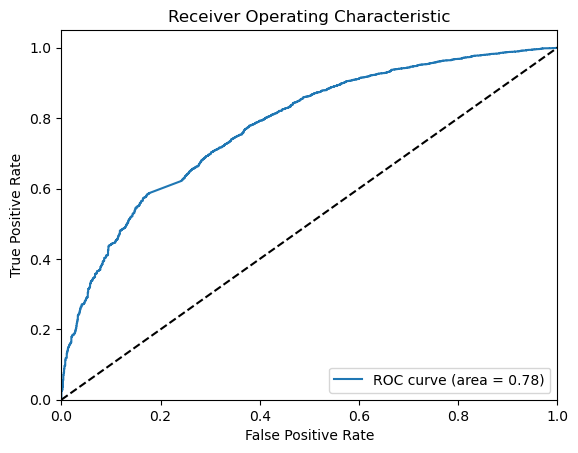

ROC Analysis with threshold 3


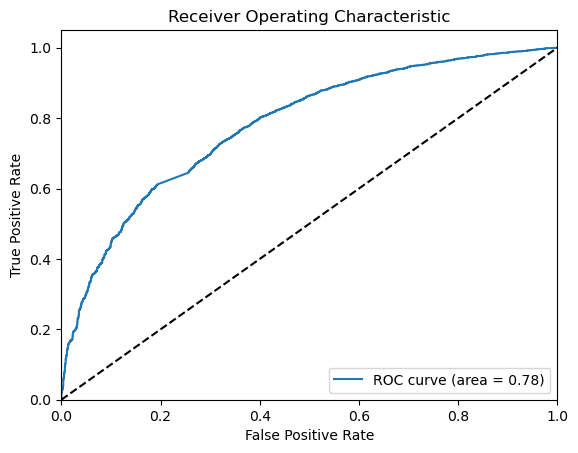

ROC Analysis with threshold 3.5


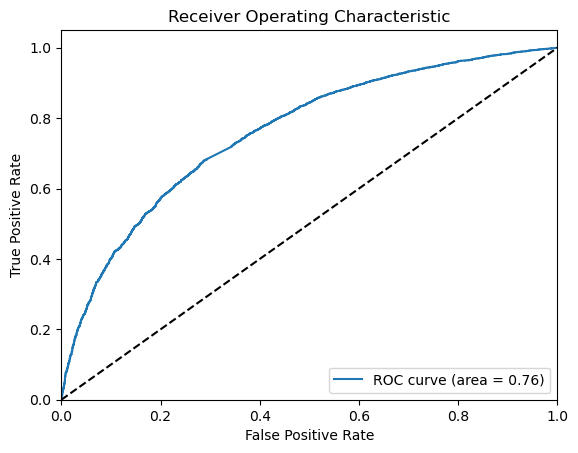

ROC Analysis with threshold 4


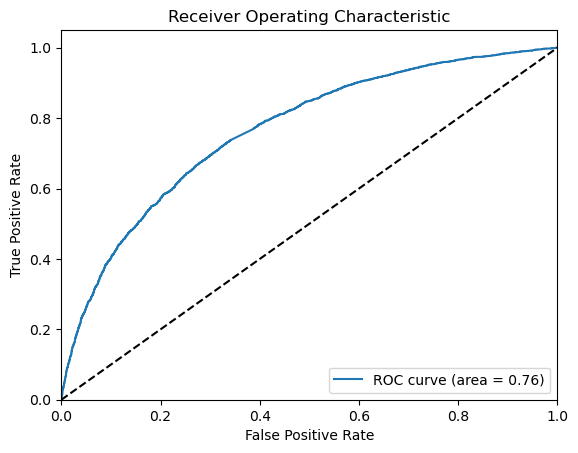

In [39]:

optimal_k_popular = range(2, 51, 2)[np.argmin(avg_rmse)]

trainset, testset = train_test_split(data, test_size=0.1)

algo = NMF(n_factors=optimal_k_popular)
algo.fit(trainset)

predictions = algo.test(testset)

thresholds = [2.5, 3, 3.5, 4]
for threshold in thresholds:
    print(f"ROC Analysis with threshold {threshold}")
    y_true = [1 if pred.r_ui >= threshold else 0 for pred in predictions]
    y_score = [pred.est for pred in predictions]

    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Q9

In [40]:
trainset = data.build_full_trainset()

algo = NMF(n_factors=20, random_state=0)
algo.fit(trainset)

V = algo.qi

In [41]:
for factor_num in range(20):
    print(f'Top 10 Values for Latent Factor {factor_num}:')
    top_movies_idx = V[:, factor_num].argsort()[-10:][::-1]

    top_movies = []
    for idx in top_movies_idx:
        movie_id = trainset.to_raw_iid(idx)
        movie_info = movies[movies['movieId'] == movie_id]
        top_movies.append((movie_info['title'].values[0], movie_info['genres'].values[0]))

    for movie, genres in top_movies:
        print(f"{movie}: {genres}")

Top 10 Values for Latent Factor 0:
It's Such a Beautiful Day (2012): Animation|Comedy|Drama|Fantasy|Sci-Fi
Polar Express, The (2004): Adventure|Animation|Children|Fantasy|IMAX
Barbarella (1968): Adventure|Comedy|Sci-Fi
Dragon Ball Z: The History of Trunks (Doragon bôru Z: Zetsubô e no hankô!! Nokosareta chô senshi - Gohan to Torankusu) (1993): Action|Adventure|Animation
Peter Pan (2003): Action|Adventure|Children|Fantasy
Neon Genesis Evangelion: Death & Rebirth (Shin seiki Evangelion Gekijô-ban: Shito shinsei) (1997): Action|Animation|Mystery|Sci-Fi
Dead Ringers (1988): Drama|Horror|Thriller
Never Let Me Go (2010): Drama|Romance|Sci-Fi
Muse, The (1999): Comedy
Gothika (2003): Horror|Thriller
Top 10 Values for Latent Factor 1:
Troll 2 (1990): Fantasy|Horror
Master of the Flying Guillotine (Du bi quan wang da po xue di zi) (1975): Action
Piranha (1978): Horror|Sci-Fi
Crash (1996): Drama|Thriller
Dragon Ball Z the Movie: The Tree of Might (Doragon bôru Z 3: Chikyû marugoto chô kessen) (19

# Q10

## A

In [42]:
from surprise import SVD
avg_rmse = []
avg_mae = []
for k in range(2, 51, 2):
    algo = SVD(n_factors=k)
    results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10, verbose=False)
    avg_rmse.append(sum(results['test_rmse']) / len(results['test_rmse']))
    avg_mae.append(sum(results['test_mae']) / len(results['test_mae']))

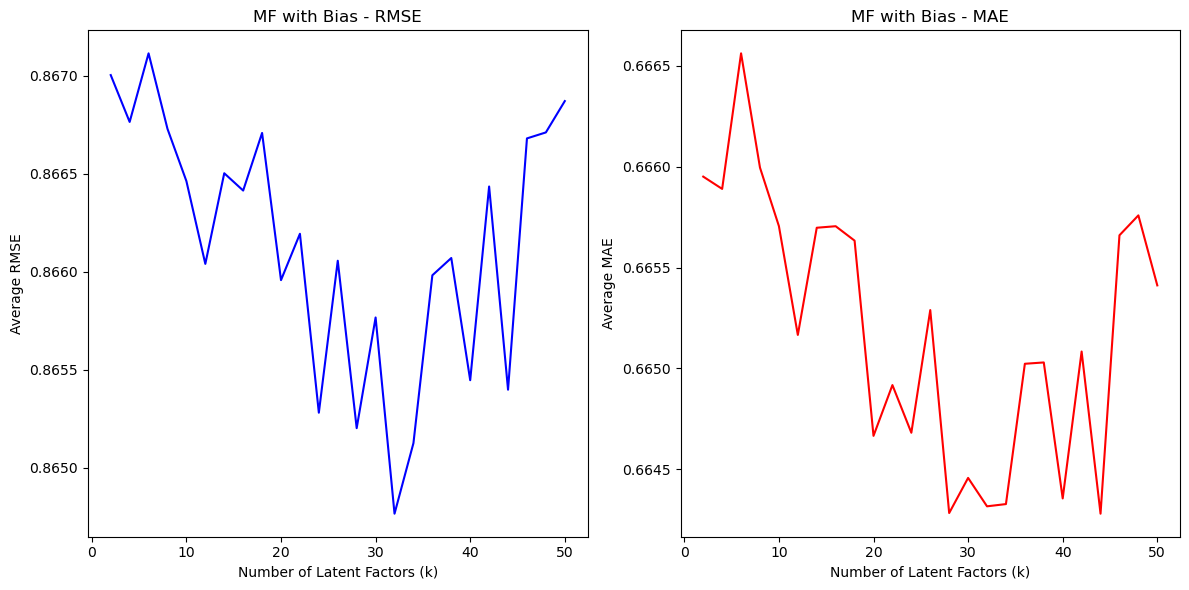

In [43]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(2, 51, 2), avg_rmse, label='Average RMSE', color='blue')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Average RMSE')
plt.title('MF with Bias - RMSE')

plt.subplot(1, 2, 2)
plt.plot(range(2, 51, 2), avg_mae, label='Average MAE', color='red')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Average MAE')
plt.title('MF with Bias - MAE')

plt.tight_layout()
plt.show()

In [44]:
min_avg_rmse = min(avg_rmse)
min_avg_mae = min(avg_mae)
optimal_k_rmse = range(2, 51, 2)[avg_rmse.index(min_avg_rmse)]
optimal_k_mae = range(2, 51, 2)[avg_mae.index(min_avg_mae)]

print(f"Optimal number of latent factors for minimum average RMSE ({min_avg_rmse}): {optimal_k_rmse}")
print(f"Optimal number of latent factors for minimum average MAE ({min_avg_mae}): {optimal_k_mae}")

Optimal number of latent factors for minimum average RMSE (0.8647660986464863): 32
Optimal number of latent factors for minimum average MAE (0.6642794600335165): 44


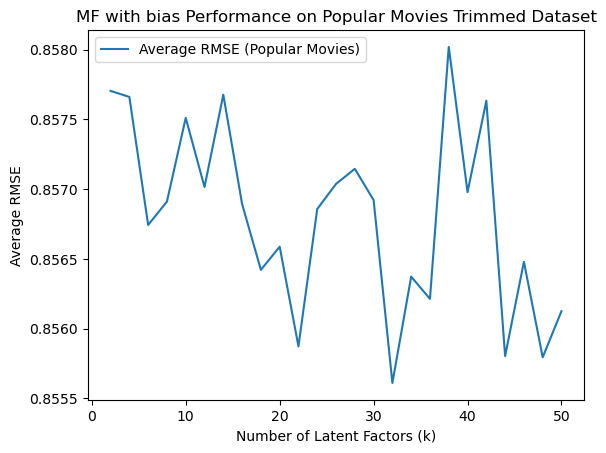

In [45]:
avg_rmse_popular = []
for k in range(2, 51, 2):
    algo = SVD(n_factors=k)
    results = cross_validate(algo, popular_trimmed_data, measures=['RMSE'], cv=10, verbose=False)
    avg_rmse_popular.append(sum(results['test_rmse']) / len(results['test_rmse']))

plt.plot(range(2, 51, 2), avg_rmse_popular, label='Average RMSE (Popular Movies)')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Average RMSE')
plt.title('MF with bias Performance on Popular Movies Trimmed Dataset')
plt.legend()
plt.show()

In [46]:
print(min(avg_rmse_popular))

0.8556109458836817


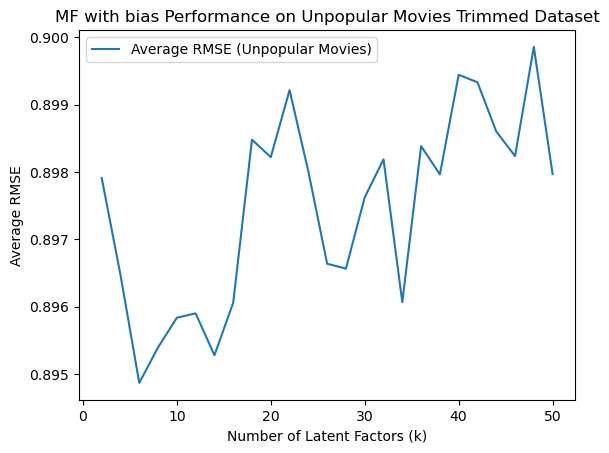

In [47]:
avg_rmse_unpopular = []
for k in range(2, 51, 2):
    algo = SVD(n_factors=k)
    results = cross_validate(algo, unpopular_trimmed_data, measures=['RMSE'], cv=10, verbose=False)
    avg_rmse_unpopular.append(sum(results['test_rmse']) / len(results['test_rmse']))

plt.plot(range(2, 51, 2), avg_rmse_unpopular, label='Average RMSE (Unpopular Movies)')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Average RMSE')
plt.title('MF with bias Performance on Unpopular Movies Trimmed Dataset')
plt.legend()
plt.show()

In [48]:
print(min(avg_rmse_unpopular))

0.8948672881168918


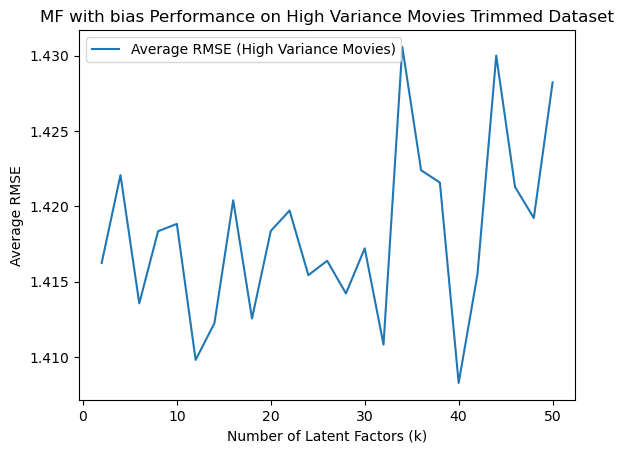

In [49]:
avg_rmse_high_variance = []
for k in range(2, 51, 2):
    algo = SVD(n_factors=k)
    results = cross_validate(algo, high_variance_trimmed_data, measures=['RMSE'], cv=10, verbose=False)
    avg_rmse_high_variance.append(sum(results['test_rmse']) / len(results['test_rmse']))

plt.plot(range(2, 51, 2), avg_rmse_high_variance, label='Average RMSE (High Variance Movies)')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Average RMSE')
plt.title('MF with bias Performance on High Variance Movies Trimmed Dataset')
plt.legend()
plt.show()

In [50]:
print(min(avg_rmse_high_variance))

1.4082743589657403


ROC Analysis with threshold 2.5


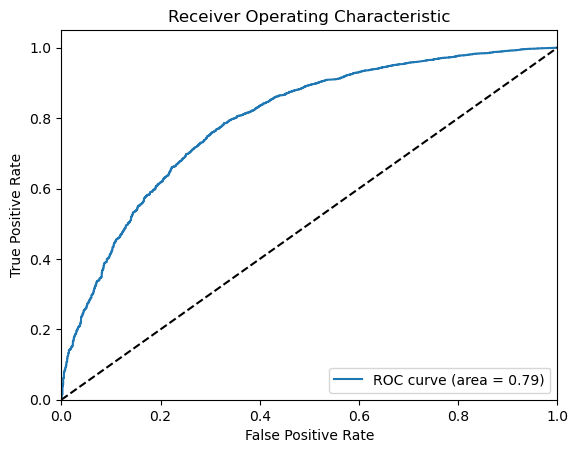

ROC Analysis with threshold 3


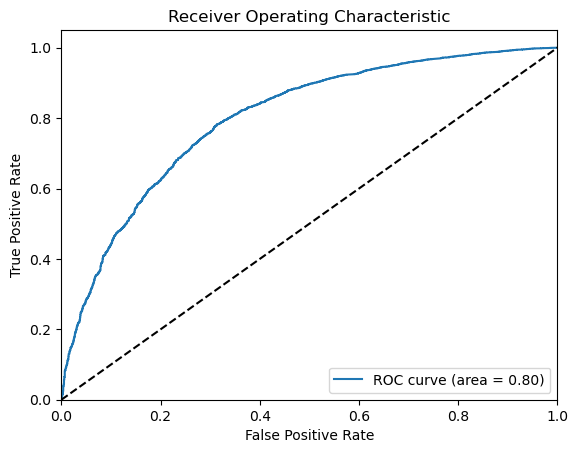

ROC Analysis with threshold 3.5


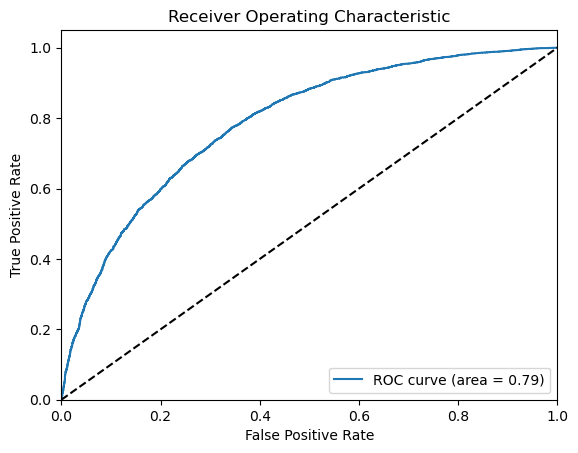

ROC Analysis with threshold 4


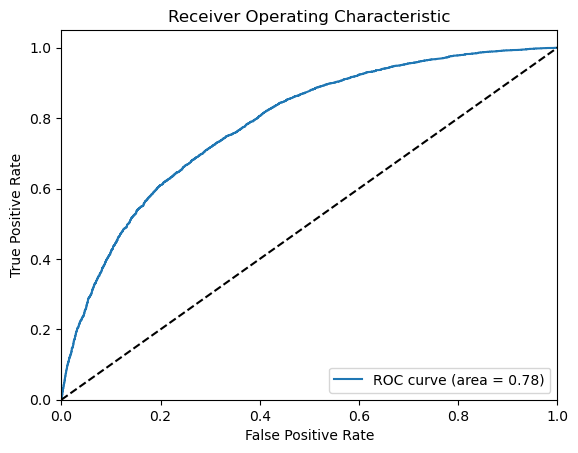

In [51]:
optimal_k_popular = range(2, 51, 2)[np.argmin(avg_rmse)]

trainset, testset = train_test_split(data, test_size=0.1)

algo = SVD(n_factors=optimal_k_popular)
algo.fit(trainset)

predictions = algo.test(testset)

thresholds = [2.5, 3, 3.5, 4]
for threshold in thresholds:
    print(f"ROC Analysis with threshold {threshold}")
    y_true = [1 if pred.r_ui >= threshold else 0 for pred in predictions]
    y_score = [pred.est for pred in predictions]

    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Q11

In [52]:
from surprise import AlgoBase

In [53]:
class NaiveCollaborativeFilter(AlgoBase):
    def __init__(self):
        AlgoBase.__init__(self)

    def fit(self, trainset):
        AlgoBase.fit(self, trainset)
        self.mean_ratings = np.mean([r for (_, _, r) in self.trainset.all_ratings()])
        return self

    def estimate(self, u, i):
        return self.mean_ratings

In [54]:
algo = NaiveCollaborativeFilter()
cross_val_results = cross_validate(algo, data, measures=['RMSE'], cv=10, verbose=True)

avg_rmse = np.mean(cross_val_results['test_rmse'])
print(f'Average RMSE: {avg_rmse}')

Evaluating RMSE of algorithm NaiveCollaborativeFilter on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    1.0502  1.0380  1.0354  1.0491  1.0518  1.0407  1.0349  1.0327  1.0552  1.0371  1.0425  0.0078  
Fit time          0.01    0.02    0.01    0.01    0.01    0.01    0.01    0.01    0.01    0.01    0.01    0.00    
Test time         0.01    0.01    0.01    0.01    0.01    0.01    0.01    0.01    0.01    0.01    0.01    0.00    
Average RMSE: 1.042516120166847


In [55]:
algo = NaiveCollaborativeFilter()
cross_val_results_popular = cross_validate(algo, popular_trimmed_data, measures=['RMSE'], cv=10, verbose=True)
avg_rmse_popular = np.mean(cross_val_results_popular['test_rmse'])
print(f'Average RMSE (Popular): {avg_rmse_popular}')

Evaluating RMSE of algorithm NaiveCollaborativeFilter on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    1.0373  1.0329  1.0339  1.0264  1.0245  1.0351  1.0288  1.0484  1.0445  1.0434  1.0355  0.0076  
Fit time          0.01    0.01    0.01    0.01    0.01    0.01    0.01    0.01    0.01    0.01    0.01    0.00    
Test time         0.01    0.01    0.01    0.01    0.06    0.01    0.01    0.01    0.01    0.01    0.01    0.02    
Average RMSE (Popular): 1.0355254147130517


In [56]:
algo = NaiveCollaborativeFilter()
cross_val_results_popular = cross_validate(algo, unpopular_trimmed_data, measures=['RMSE'], cv=10, verbose=True)
avg_rmse_popular = np.mean(cross_val_results_popular['test_rmse'])
print(f'Average RMSE (Unpopular): {avg_rmse_popular}')

Evaluating RMSE of algorithm NaiveCollaborativeFilter on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    1.1316  1.1220  1.0943  1.0920  1.1156  1.0969  1.1359  1.0778  1.0891  1.1284  1.1084  0.0196  
Fit time          0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    
Average RMSE (Unpopular): 1.1083611327448277


In [57]:
algo = NaiveCollaborativeFilter()
cross_val_results_popular = cross_validate(algo, high_variance_trimmed_data, measures=['RMSE'], cv=10, verbose=True)
avg_rmse_popular = np.mean(cross_val_results_popular['test_rmse'])
print(f'Average RMSE (High Variance): {avg_rmse_popular}')

Evaluating RMSE of algorithm NaiveCollaborativeFilter on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    1.5756  1.3807  1.4901  1.5657  1.5921  1.4463  1.3645  1.5088  1.6221  1.5410  1.5087  0.0837  
Fit time          0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    
Average RMSE (High Variance): 1.5086878169083466


In [58]:
trainset, testset = train_test_split(data, test_size=0.1, random_state=42)

knn_model = KNNWithMeans(k=22)
nmf_model = NMF(n_factors=18)
mf_model = SVD(n_factors=46)

knn_model.fit(trainset)
nmf_model.fit(trainset)
mf_model.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


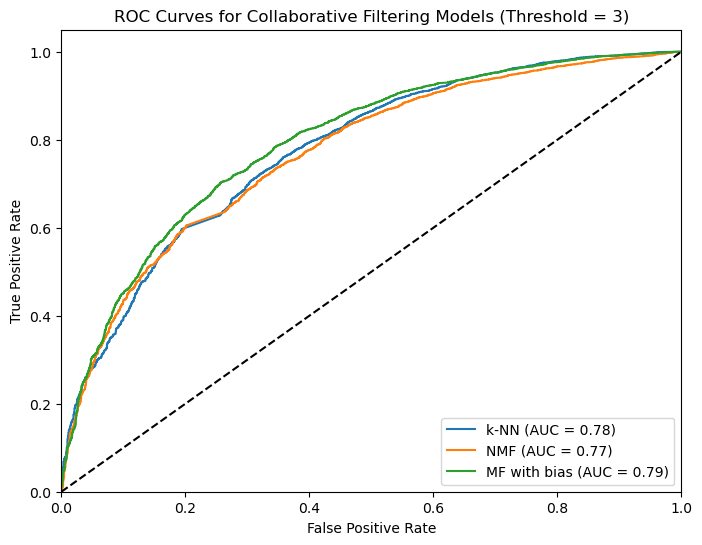

In [59]:
def plot_roc_curve(model, testset, model_name):
    predictions = model.test(testset)
    y_true = [1 if pred.r_ui >= 3 else 0 for pred in predictions]
    y_score = [pred.est for pred in predictions]

    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.figure(figsize=(8, 6))

plot_roc_curve(knn_model, testset, 'k-NN')
plot_roc_curve(nmf_model, testset, 'NMF')
plot_roc_curve(mf_model, testset, 'MF with bias')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Collaborative Filtering Models (Threshold = 3)')
plt.legend(loc="lower right")
plt.show()

# Q13 - Q16

In [ ]:
import zipfile
import os

# Path to your ZIP file
zip_file_path = 'MSLR-WEB10K.zip'
extract_folder_path = 'MSLR-WEB10K'

# Open the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # List all files in the ZIP
    zip_contents = zip_ref.namelist()
    print("Contents of the ZIP file:")
    for f in zip_contents:
        print(f)

    # Example: Extract all files
    zip_ref.extractall(extract_folder_path)
    print(f"All files extracted to {extract_folder_path}")

os.remove(zip_file_path)

In [ ]:
def load_mslr_data(file_path):
    relevance_labels = []
    qids = []
    features = []

    with open(file_path, 'r') as file:
        for line in file:
            components = line.strip().split()
            relevance_labels.append(int(components[0]))
            qid = int(components[1].split(':')[1])
            qids.append(qid)
            feature_vector = [0.0] * 136
            for component in components[2:]:
                feature_index, feature_value = component.split(':')
                feature_vector[int(feature_index)-1] = float(feature_value)

            features.append(feature_vector)
    data = pd.DataFrame(features)
    data.columns = [f'feature_{i}' for i in range(1, 137)]
    data['qid'] = qids
    data['relevance'] = relevance_labels
    return data

In [ ]:
import lightgbm as lgb
from sklearn.metrics import ndcg_score

In [ ]:
base_path = 'MSLR-WEB10K/Fold{fold_number}/'
folds = range(1, 6)
# construct folds
for fold in folds:
    print(f'Fold {fold}: ')
    train_file = base_path.format(fold_number=fold) + 'train.txt'
    test_file = base_path.format(fold_number=fold) + 'test.txt'
    vali_file = base_path.format(fold_number=fold) + 'vali.txt'
    train_data = load_mslr_data(train_file)
    test_data = load_mslr_data(test_file)
    vali_data = load_mslr_data(vali_file)

    all_data = pd.concat([train_data, test_data, vali_data], ignore_index=True)
    num_unique_queries = all_data['qid'].nunique()
    print(f'Total number of unique queries: {num_unique_queries}')

    label_distribution = all_data['relevance'].value_counts(normalize=True).sort_index()
    print('Distribution of relevance labels:')
    print(label_distribution)

    X_train = train_data.drop(['relevance', 'qid'], axis=1).values
    y_train = train_data['relevance'].values
    qid_train = train_data.groupby('qid').size().to_frame('size')['size'].values

    X_test = test_data.drop(['relevance', 'qid'], axis=1).values
    y_test = test_data['relevance'].values
    qid_test = test_data.groupby('qid').size().to_frame('size')['size'].values

    train_lgb = lgb.Dataset(X_train, label=y_train, group=qid_train, free_raw_data=False)
    test_lgb = lgb.Dataset(X_test, label=y_test, group=qid_test, free_raw_data=False, reference=train_lgb)

    params = {
        'objective': 'lambdarank',
        'metric': 'ndcg',
        'ndcg_eval_at': [3, 5, 10],
        'learning_rate': 0.1,
        'num_leaves': 31,
        'min_data_in_leaf': 1,
        'verbosity': -1
    }

    gbm = lgb.train(params, train_lgb, num_boost_round=100, valid_sets=[test_lgb])

    y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

    ndcg_at_3 = ndcg_score([y_test], [y_pred], k=3)
    ndcg_at_5 = ndcg_score([y_test], [y_pred], k=5)
    ndcg_at_10 = ndcg_score([y_test], [y_pred], k=10)

    print(f"nDCG@3: {ndcg_at_3}, nDCG@5: {ndcg_at_5}, nDCG@10: {ndcg_at_10}")

    feature_importance = gbm.feature_importance(importance_type='gain')
    feature_names = [f'feature_{i}' for i in range(1, 137)]
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
    top_5_features = importance_df.sort_values(by='Importance', ascending=False).head(5)

    print("Top 5 most important features:")
    print(top_5_features)

    top_20_features = importance_df['Feature'].head(20).tolist()

    X_train_reduced = train_data.drop(top_20_features + ['relevance', 'qid'], axis=1).values
    X_test_reduced = test_data.drop(top_20_features + ['relevance', 'qid'], axis=1).values

    train_lgb_reduced = lgb.Dataset(X_train_reduced, label=y_train, group=qid_train, free_raw_data=False)
    test_lgb_reduced = lgb.Dataset(X_test_reduced, label=y_test, group=qid_test, free_raw_data=False)
    gbm_reduced = lgb.train(params, train_lgb_reduced, num_boost_round=100, valid_sets=[test_lgb_reduced])

    y_pred = gbm_reduced.predict(X_test_reduced, num_iteration=gbm.best_iteration)

    ndcg_at_3 = ndcg_score([y_test], [y_pred], k=3)
    ndcg_at_5 = ndcg_score([y_test], [y_pred], k=5)
    ndcg_at_10 = ndcg_score([y_test], [y_pred], k=10)

    print(f"Reduced: nDCG@3: {ndcg_at_3}, nDCG@5: {ndcg_at_5}, nDCG@10: {ndcg_at_10}")

    bottom_60_features = importance_df['Feature'].tail(60).tolist()

    X_train_reduced_60 = train_data.drop(bottom_60_features + ['relevance', 'qid', 'feature_1'], axis=1).values
    X_test_reduced_60 = test_data.drop(bottom_60_features + ['relevance', 'qid', 'feature_1'], axis=1).values

    train_lgb_reduced_60 = lgb.Dataset(X_train_reduced_60, label=y_train, group=qid_train, free_raw_data=False)
    test_lgb_reduced_60 = lgb.Dataset(X_test_reduced_60, label=y_test, group=qid_test, free_raw_data=False)
    gbm_reduced_60 = lgb.train(params, train_lgb_reduced_60, num_boost_round=100, valid_sets=[test_lgb_reduced_60])

    y_pred = gbm_reduced_60.predict(X_test_reduced_60, num_iteration=gbm.best_iteration)

    ndcg_at_3 = ndcg_score([y_test], [y_pred], k=3)
    ndcg_at_5 = ndcg_score([y_test], [y_pred], k=5)
    ndcg_at_10 = ndcg_score([y_test], [y_pred], k=10)

    print(f"Reduced 60: nDCG@3: {ndcg_at_3}, nDCG@5: {ndcg_at_5}, nDCG@10: {ndcg_at_10}")

Fold 1: 
Total number of unique queries: 10000
Distribution of relevance labels:
relevance
0    0.520136
1    0.321849
2    0.132855
3    0.017761
4    0.007400
Name: proportion, dtype: float64
nDCG@3: 0.5307212739772434, nDCG@5: 0.6608397947263838, nDCG@10: 0.7480978396024439
Top 5 most important features:
         Feature    Importance
133  feature_134  23829.122202
7      feature_8   4256.551221
54    feature_55   4055.480095
107  feature_108   4049.734452
129  feature_130   3655.614255
Reduced: nDCG@3: 0.5307212739772434, nDCG@5: 0.6608397947263838, nDCG@10: 0.7799082337019198
Reduced 60: nDCG@3: 0.6173196815056892, nDCG@5: 0.5557046000229097, nDCG@10: 0.5914468270998005
Fold 2: 
Total number of unique queries: 10000
Distribution of relevance labels:
relevance
0    0.520136
1    0.321849
2    0.132855
3    0.017761
4    0.007400
Name: proportion, dtype: float64
nDCG@3: 1.0, nDCG@5: 0.9999999999999999, nDCG@10: 0.933745776545611
Top 5 most important features:
         Feature    Imp